In [1]:
import os
import pandas as pd

from solver import processing
from solver import persistence

In [2]:
### FEATURE PARAMETERS
# prediction target
feature_predict = 'P_avg'
# prediction inputs from turbine data
features_train = ['P_avg']

### TRAIN/VAL/TEST SPLIT
train_years = [2013, 2014, 2015, 2016]
test_years = [2017]

### FEATURE ENGINEERING PARAMETERS
MA_CONSTANT = 3 # moving average smoothing parameter

In [3]:
TURBINE_ID = 'R80711'
DATA_DIR = '../datasets/after_imputation'

# define datasets
data_link = os.path.join(DATA_DIR, 'turbine_{}.csv'.format(TURBINE_ID))
# read datasets
dataset = processing.read_dataset(data_link)

In [4]:
# Smooth with Moving Average
if feature_predict in features_train:
    dataset = processing.smooth(
        dataset,
        cols_to_smooth=features_train,
        ma_constant=MA_CONSTANT
    )

In [5]:
# Split data to train and test
test_dates = dataset.loc[dataset['Date_time'].dt.year.isin(test_years), 'Date_time'].values
train = dataset.loc[dataset['Date_time'].dt.year.isin(train_years), feature_predict].values
test = dataset.loc[dataset['Date_time'].dt.year.isin(test_years), feature_predict].values

In [6]:
# Check if there are any missing timesteps in data
mask = pd.to_datetime(dataset['Date_time']).diff() > '01:00:00'
dataset['Date_time'][mask]
# Conclusion: no missing timesteps

Series([], Name: Date_time, dtype: datetime64[ns, UTC])

# Build and forecast with persistance model

In [7]:
# find out how many days are in between years
# define years of interest
year = 2016

data_ago = dataset.copy()
data_ago['Year'] = pd.to_datetime(data_ago['Date_time']).dt.year
data_ago = data_ago[data_ago['Year'].isin([year])]
 
print('In year {} there was {} samples'.format(year, data_ago.shape[0]))

In year 2016 there was 8784 samples


In [8]:
# -------------------
# evaluate each Persistence model
# -------------------
# FORECAST HORIZON
N_OUT = 3

# sample persistence:
pred_sample, mae, mse, sm = persistence.evaluate_model(persistence.sample_persistence, train, test, N_OUT)
print(" Sample persistence: Horizon: {} \t MAE: {}  RMSE: {}  sMAPE: {}".format(
    N_OUT, round(mae, 3), round(mse, 3), round(sm, 3)))

# daily persistence
pred, mae, mse, sm = persistence.evaluate_model(persistence.daily_persistence, train, test, N_OUT)
print(" Daily persistence: Horizon:  {} \t MAE: {}  RMSE: {}  sMAPE: {}".format(
    N_OUT, round(mae, 3), round(mse, 3), round(sm, 3)))

# weekly persistence
pred, mae, mse, sm = persistence.evaluate_model(persistence.weekly_persistence, train, test, N_OUT)
print(" Weekly persistence: Horizon: {} \t MAE: {}  RMSE: {}  sMAPE: {}".format(
    N_OUT, round(mae, 3), round(mse, 3), round(sm, 3)))

# yearly persistence (might be out of bounds)
try:
    pred, mae, mse, sm = persistence.evaluate_model(persistence.year_ago_persistence, train, test, N_OUT)
    print(" Yearly persistence: Horizon: {} \t MAE: {}  RMSE: {}  sMAPE: {}".format(
        N_OUT, round(mae, 3), round(mse, 3), round(sm, 3)))
except ValueError:
    print(" Yearly persistance model is not available as forecast horizon is too large!")

 Sample persistence: Horizon: 3 	 MAE: 148.072  RMSE: 223.98  sMAPE: 0.695
 Daily persistence: Horizon:  3 	 MAE: 412.816  RMSE: 581.906  sMAPE: 1.205
 Weekly persistence: Horizon: 3 	 MAE: 425.973  RMSE: 594.711  sMAPE: 1.226
 Yearly persistence: Horizon: 3 	 MAE: 427.393  RMSE: 582.882  sMAPE: 1.231


/Users/macbook/Desktop/Magistras/second_year/wind_power_forecasting/solver/processing.py:15: RuntimeWarning: invalid value encountered in true_divide
  sm = np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
/Users/macbook/Desktop/Magistras/second_year/wind_power_forecasting/solver/processing.py:15: RuntimeWarning: invalid value encountered in true_divide
  sm = np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
/Users/macbook/Desktop/Magistras/second_year/wind_power_forecasting/solver/processing.py:15: RuntimeWarning: invalid value encountered in true_divide
  sm = np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


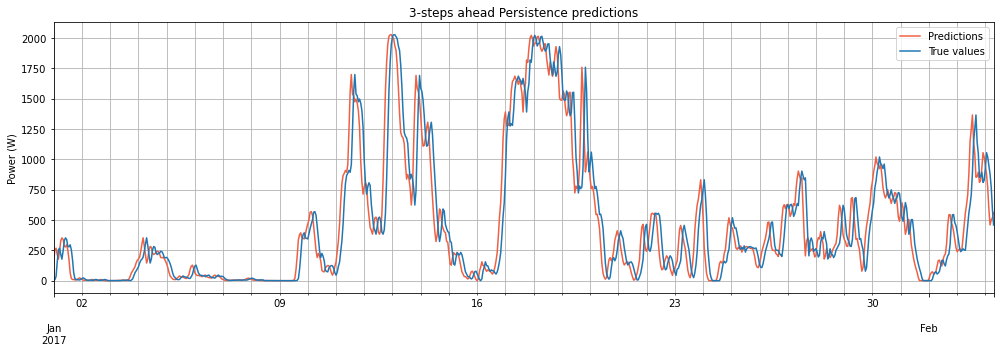

In [10]:
# Plot results
predictions = pd.Series(test, index=test_dates)
true = pd.Series(pred_sample, index=test_dates)

# plot predicitons
processing.plot_series_predictions(true, predictions, N_OUT, method='Persistence')